In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import re
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
'''
# The 2 lines below will print all possible output without requiring a print statement
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
'''
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['train.csv', 'gender_submission.csv', 'test.csv']


# Table of contents :

## 1. EDA
*   ### 1.1 EDA Part 1 - no vizualizations
*   ### 1.2 EDA Part 2 - vizualizations


In [2]:
# Import data : training and test set

df_train = pd.read_csv("../input/train.csv")
df_test = pd.read_csv("../input/test.csv")

# Join Datasets for EDA

df_train['dataset'] = 'training'
df_test['dataset'] = 'test'

df = df_train.append(df_test)
df.reset_index(inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Note: in this notebook, we perform data vizualization, cleaning, feature enginering and preprocessing(ie. feature scaling) on the complete test + training dataset. This implies some extent of 'data leakage' which may lead to over-optimistic prediction for model generalization to unseen data

### 1. EDA

#### 1.1 EDA Part 1 - no vizualization

In [3]:
print(df.columns)
print('\n')
print('===========================================================================')
print('\n')
print(df.shape)
print('\n')
print('===========================================================================')
print('\n')
print(df.iloc[:, [0,1,2,5,6]].describe())
print(df.iloc[:, [7,9]].describe())
print(df.iloc[:, [3,4,8,10]].describe())

print('\n')
print('===========================================================================')
print('\n')

# identifying important features in variables (missing values, number of unique values
df_missing = pd.DataFrame({'column': df.columns, 'Data type': df.dtypes ,'Missing': df.isnull().sum(), 'unique_val': df.nunique()})
print(df_missing)


Index(['index', 'Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch',
       'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket',
       'dataset'],
      dtype='object')




(1309, 14)




             index          Age        Parch
count  1309.000000  1046.000000  1309.000000
mean    369.478992    29.881138     0.385027
std     248.767105    14.413493     0.865560
min       0.000000     0.170000     0.000000
25%     163.000000    21.000000     0.000000
50%     327.000000    28.000000     0.000000
75%     563.000000    39.000000     0.000000
max     890.000000    80.000000     9.000000
       PassengerId
count  1309.000000
mean    655.000000
std     378.020061
min       1.000000
25%     328.000000
50%     655.000000
75%     982.000000
max    1309.000000
              Fare       Pclass        SibSp
count  1308.000000  1309.000000  1309.000000
mean     33.295479     2.294882     0.498854
std      51.758668     0.837836     1.041658
min       0.000000     1.000000     0.000000


#### 1.1 EDA Part 2 - vizualizations

In [4]:
plt.style.available #show all styles available
plt.style.use('ggplot')

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


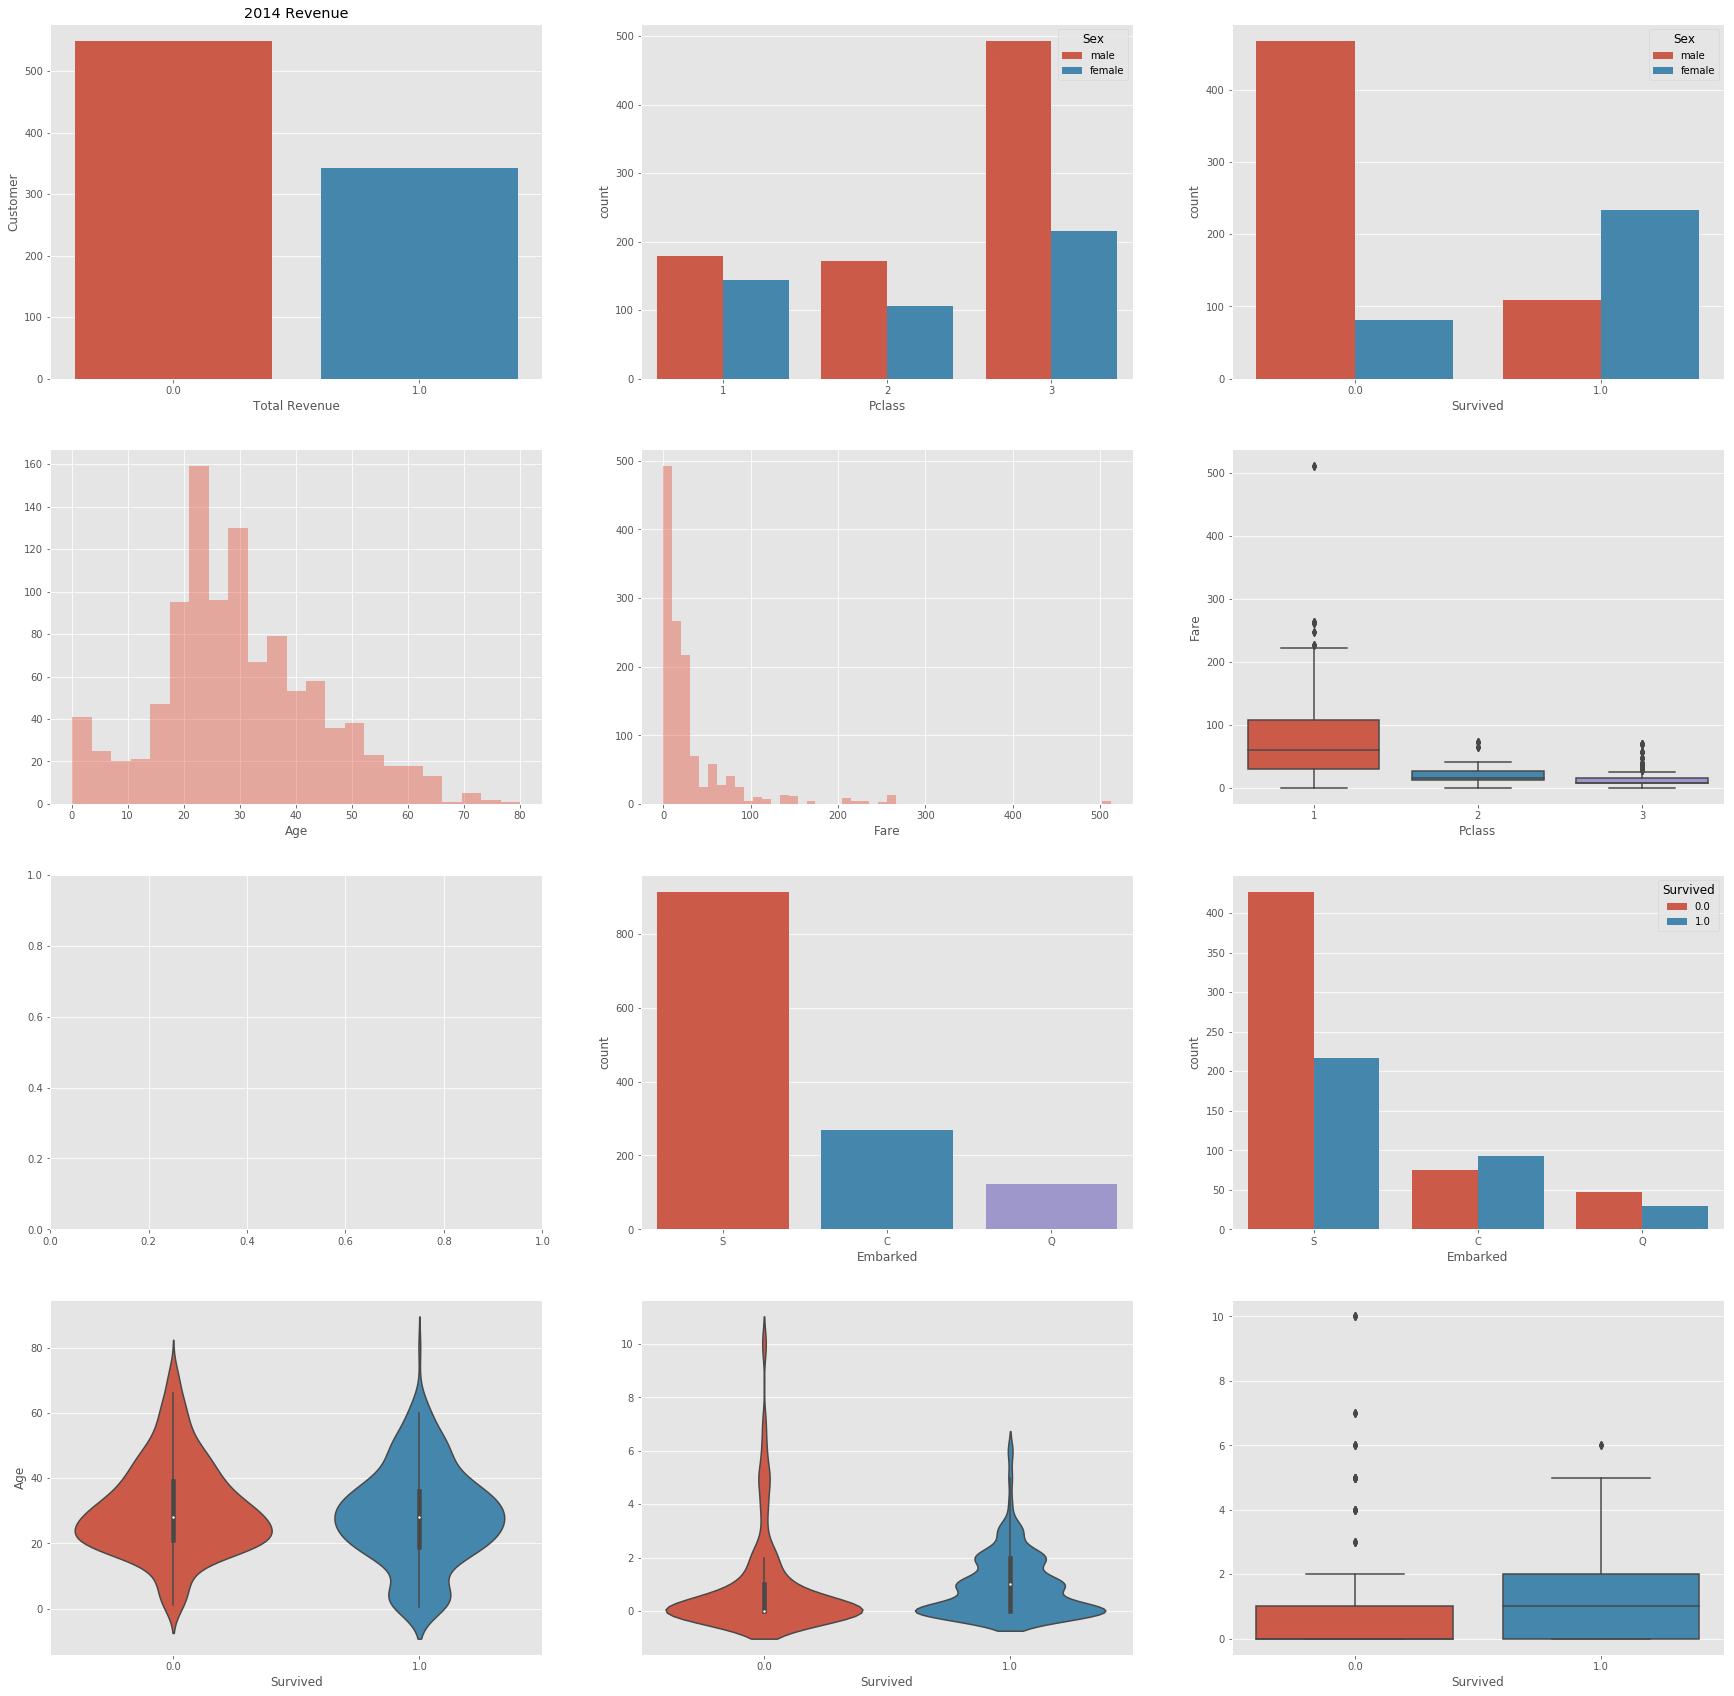

In [5]:

fig, ax = plt.subplots(4, 3, figsize=(30, 30))
sns.countplot(df['Survived'], ax=ax[0, 0])
ax[0, 0].set(title='2014 Revenue', xlabel='Total Revenue', ylabel='Customer')
sns.countplot(df['Pclass'], hue=df['Sex'], ax=ax[0, 1])
sns.countplot(df['Survived'], hue=df['Sex'], ax=ax[0, 2])
sns.distplot(df['Age'].dropna(), kde=False, ax=ax[1, 0])
sns.distplot(df['Fare'].dropna(), kde=False, ax=ax[1, 1])
sns.boxplot(x=df['Pclass'], y=df['Fare'].dropna(), ax=ax[1, 2])
sns.countplot(df['Embarked'], ax=ax[2, 1])
sns.countplot(df['Embarked'], hue=df['Survived'], ax=ax[2, 2])
sns.violinplot(x='Survived', y='Age', data=df, ax=ax[3, 0])
sns.violinplot(x='Survived', y=(df['Parch']+df['SibSp']), data=df, ax=ax[3, 1])
sns.boxplot(x=df['Survived'], y=(df['SibSp']+df['Parch']).dropna(), ax=ax[3, 2])

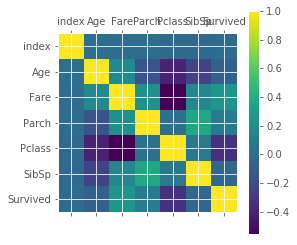

In [6]:
num_col = df.columns.drop(['Name', 'PassengerId', 'Ticket', 'Cabin', 'Sex', 'Embarked', 'dataset'])
df_num = df[num_col]
plt.matshow(df_num.corr())
plt.xticks(range(len(df_num.columns)), df_num.columns)
plt.yticks(range(len(df_num.columns)), df_num.columns)
plt.colorbar()
plt.show()

#### EDA - conclusion

##### 1. Missing values
   * Age : 263 => filled in with mean of Pclass and Sex 
   * Cabin : 1014 => see feature enginering
   * Embarked : 2 => To drop
   * Fare : 1 => filled in with mean of Pclass, Embarked and Cabin 
   
##### 2. Outliers
   * Fare : many outliers => see feature enginering
   
##### 3. abnormal zero values
   * Fare : 17 zero value. Not possible to infer from other variable such as 'Ticket' => To drop

### 2. Feature enginering

#### 2.1 Embarked

In [7]:
# Fill missing values 'Embarked' with most recurrent value
df['Embarked'].fillna(df['Embarked'].agg('mode')[0], inplace=True)

# Separetly applied in order to avoid data leakage
Embarked_value = df_train['Embarked'].mode()[0]
df_train['Embarked'].fillna(Embarked_value, inplace=True)
df_test['Embarked'] = df_test['Embarked'].fillna(Embarked_value)

#### 2.2 Age

In [8]:
# Age : mean per Pclass and Sex
df["Age"] = df.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.mean()))

# Separetly applied in order to avoid data leakage
df_train["Age"] = df_train.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.mean()))
df_test["Age"] = df_train.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.mean()))

#### 2.3 Cabin

In [9]:
# Cabin : dummy on private cabin or not
df['cabin_dummy'] = df.apply(lambda x: 1 if pd.notnull(x['Cabin']) else 0, axis=1)

# Separetly applied in order to avoid data leakage
df_train['cabin_dummy'] = df_train.apply(lambda x: 1 if pd.notnull(x['Cabin']) else 0, axis=1)
df_test['cabin_dummy'] = df_test.apply(lambda x: 1 if pd.notnull(x['Cabin']) else 0, axis=1)

#### 2.4 Fare

In [10]:
# Fare : fill in zero and missing values with mean per Pclass, Sex, Cabin and Embarked
df['Fare'] = df.apply(lambda x: np.nan if x.Fare == 0 else x.Fare, axis=1) #replace zero values with NaN
df['Fare'] = df.groupby(['Sex', 'Pclass', 'cabin_dummy', 'Embarked'])['Fare'].transform(lambda x: x.fillna(x.mean()))
df['Fare'] = df['Fare'] / df.groupby('Ticket')["Name"].transform('count')

# Separetly applied in order to avoid data leakage
df_gb_fare = df.groupby(['Sex', 'Pclass', 'cabin_dummy', 'Embarked'])['Fare'] # for not to proxy missing vals in test using train proxies
df_train['Fare'] = df_train.apply(lambda x: np.nan if x.Fare == 0 else x.Fare, axis=1)
df_train['Fare'] = df_gb_fare.transform(lambda x: x.fillna(x.mean()))
df_train['Fare'] = df_train['Fare'] / df_train.groupby('Ticket')["Name"].transform('count')

df_test['Fare'] = df_test.apply(lambda x: np.nan if x.Fare == 0 else x.Fare, axis=1)
df_test['Fare'] = df_gb_fare.transform(lambda x: x.fillna(x.mean()))
df_test['Fare'] = df_test['Fare'] / df_test.groupby('Ticket')["Name"].transform('count')

#### 2.5 Title

In [11]:
# In order to have all possible values
df['Title'] = df['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
df.Title.value_counts()

df_train['Title'] = df_train['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
df_test['Title'] = df_test['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

# Create 4 categories : 'Mr', 'Miss', 'Mrs'and 'Master'
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['the Countess', 'Mme', 'Dona']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms', 'Lady']:
        return 'Miss'
    elif title in ['Dr', 'Sir']:
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
    
df['Title']=df.apply(replace_titles, axis=1)
df_train['Title']=df_train.apply(replace_titles, axis=1)
df_test['Title']=df_test.apply(replace_titles, axis=1)

#### 2.6 Creation of prediction vs. target variables from training set

While the test_set will be used for generalization estimation as a validation test, we need to create a 'cross-validation set to help us evaluate and compare different models. Note: here, we observe data leakage between our train and cross-validation set.

In [12]:
'''
df_train = df[df['dataset']=='training']
df_validation = df[df['dataset']=='test']
'''

"\ndf_train = df[df['dataset']=='training']\ndf_validation = df[df['dataset']=='test']\n"

#### 2.7 Final feature selection and dummy creation

In [13]:
# columns to use
feature_list = ['Age', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp', 'cabin_dummy', 'Title', 'Survived']
predictor_feature_list = ['Age', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp', 'cabin_dummy', 'Title']
target_feature = 'Survived'

# train/test dummy creation
df_train = df_train[feature_list]
df_train = pd.get_dummies(df_train, drop_first=True)

df_test_submission = df_test
df_test = df_test[predictor_feature_list]
X_test = pd.get_dummies(df_test, drop_first=True)

# train dataset split target/predictors (df_test only contains predictors)
X_train = df_train.drop(labels='Survived', axis=1)
y_train = pd.DataFrame(df_train.loc[:, 'Survived'])

#### 2.8 Train/Validation(test.csv) feature equality check

Because we applied our feature engineering separetly to each dataset, we need to make sure that they have same size and features. Differences are often generated from when performing one_hot_encoding or to_dummy to categorical features with different string values.

In [14]:
# Compare final input data shapes
print(X_train.shape)
print(X_test.shape)
# => The missmatch must come from different values for object variables leading to different string created

# List of features in train but not in test
col_train = list(X_train.columns)
col_test = list(X_test.columns)
col_diff_1 = []

for col in col_train:
    if col not in col_test:
        X_test[col] = 0
        

# List of features in test but not in train
col_diff_2 = []
for col in col_test:
    if col not in col_train:
        X_train[col] = 0

# Result

print(X_train.shape)
print(X_test.shape)

(891, 12)
(418, 12)
(891, 12)
(418, 12)


### 3. Model development

In this section we will first test a large number of possible classifiers without tuning. Then we will select the best 3 models and improve them through gridSearch tuning

In [15]:
# Pre-processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ML algorithms
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.naive_bayes import GaussianNB


from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

# Model evaluation


#### 3.1. Creation of train/test(cv) sets

We will use the test set (cross-validation set) to evaluate the different ML algorithms. The real test set (from test.csv) will act as validation test to provide a unbiased estimate of the generalization possibilities.

In [16]:
##(2)X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

#### 3.2. Cross-validation settings

In [17]:
kfold = StratifiedKFold(n_splits=10, random_state=2)

#### 3.3. List of ML classifier algorithms to be tested


In [18]:
random_state=2
classifiers_list = []
classifiers_list.append(('LR', LogisticRegression(random_state=random_state)))
classifiers_list.append(('Knn', KNeighborsClassifier()))
classifiers_list.append(('SVC', SVC(random_state=random_state)))
classifiers_list.append(('DTC', DecisionTreeClassifier(random_state=random_state)))
classifiers_list.append(('RFC', RandomForestClassifier(random_state=random_state)))
classifiers_list.append(('Ada', AdaBoostClassifier(random_state=random_state)))
classifiers_list.append(('GB', GradientBoostingClassifier(random_state=random_state)))
classifiers_list.append(('XGB', XGBClassifier(random_state=random_state)))
classifiers_list.append(('ETC', ExtraTreesClassifier(random_state=random_state)))
classifiers_list.append(('MLP', MLPClassifier(random_state=random_state)))
classifiers_list.append(('GNB', GaussianNB()))

#### 3.4. Initiate Pipeline to test all models with no tuning

In [19]:
cv_scores_list_acc = []
cv_scores_list_auc = []
##(2)test_score_list = []
all_results_acc = []
class_name_list = []
std_cv_scores_list_acc =[]

for name, clf in classifiers_list:
    class_name_list.append(name)
    steps=[('scaler', StandardScaler()),('clf', clf)]
    pipeline = Pipeline(steps)
    pipeline.fit(X_train, y_train)
    
    scores_acc = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='accuracy')
    mean_cv_score_acc = np.mean(scores_acc)
    cv_scores_list_acc.append(mean_cv_score_acc)
    
    std_cv_score_acc = np.std(scores_acc)
    std_cv_scores_list_acc.append(std_cv_score_acc)
    
    scores_auc = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='roc_auc')
    all_results_acc.append(scores_auc)
    
    mean_cv_score_auc = np.mean(scores_auc)
    cv_scores_list_auc.append(mean_cv_score_auc)
    
    ##(2)test_score = pipeline.score(X_test, y_test)
    ##(2)test_score_list.append(test_score)
    #test_score_acc = pipeline.accuracy_score(X_test, y_test)

df_clf_recap_1 = pd.DataFrame({'clf_name': classifiers_list, 'mean_cv_score_acc':cv_scores_list_acc, 
                               'std_cv_score_acc':std_cv_scores_list_acc, 'mean_cv_score_auc':cv_scores_list_auc})


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversion

[Text(0, 0, 'LR'),
 Text(0, 0, 'Knn'),
 Text(0, 0, 'SVC'),
 Text(0, 0, 'DTC'),
 Text(0, 0, 'RFC'),
 Text(0, 0, 'Ada'),
 Text(0, 0, 'GB'),
 Text(0, 0, 'XGB'),
 Text(0, 0, 'ETC'),
 Text(0, 0, 'MLP'),
 Text(0, 0, 'GNB')]

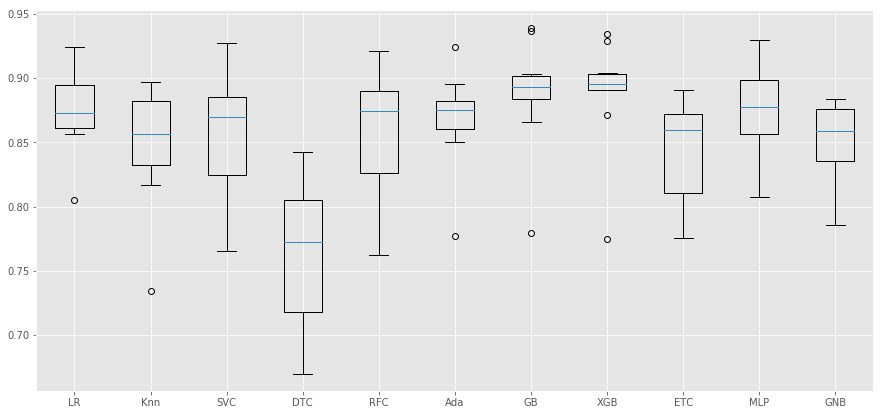

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.boxplot(all_results_acc)
ax.set_xticklabels(class_name_list)

In [21]:
df_clf_recap_1['evaluation metric'] = (df_clf_recap_1['mean_cv_score_acc'] + df_clf_recap_1['mean_cv_score_auc']) / 2
df_clf_recap_1.sort_values('mean_cv_score_auc', ascending=False, inplace=True)
df_clf_recap_1

,clf_name,mean_cv_score_acc,std_cv_score_acc,mean_cv_score_auc,evaluation metric
7,"(XGB, XGBClassifier(base_score=0.5, booster='g...",0.822755,0.036397,0.888371,0.855563
6,"(GB, ([DecisionTreeRegressor(criterion='friedm...",0.832781,0.030293,0.887492,0.860136
9,"(MLP, MLPClassifier(activation='relu', alpha=0...",0.836239,0.032906,0.875184,0.855711
0,"(LR, LogisticRegression(C=1.0, class_weight=No...",0.833892,0.026510,0.874780,0.854336
5,"(Ada, (DecisionTreeClassifier(class_weight=Non...",0.819385,0.033557,0.868062,0.843724
4,"(RFC, (DecisionTreeClassifier(class_weight=Non...",0.803704,0.037742,0.859830,0.831767
2,"(SVC, SVC(C=1.0, cache_size=200, class_weight=...",0.824953,0.031290,0.858894,0.841923
10,"(GNB, GaussianNB(priors=None, var_smoothing=1e...",0.786724,0.025818,0.851240,0.818982
1,"(Knn, KNeighborsClassifier(algorithm='auto', l...",0.803679,0.031678,0.847098,0.825388
8,"(ETC, (ExtraTreeClassifier(class_weight=None, ...",0.811531,0.034157,0.844564,0.828047


In [22]:
np.linspace(1, 32, endpoint=True)

array([ 1.        ,  1.63265306,  2.26530612,  2.89795918,  3.53061224,
        4.16326531,  4.79591837,  5.42857143,  6.06122449,  6.69387755,
        7.32653061,  7.95918367,  8.59183673,  9.2244898 ,  9.85714286,
       10.48979592, 11.12244898, 11.75510204, 12.3877551 , 13.02040816,
       13.65306122, 14.28571429, 14.91836735, 15.55102041, 16.18367347,
       16.81632653, 17.44897959, 18.08163265, 18.71428571, 19.34693878,
       19.97959184, 20.6122449 , 21.24489796, 21.87755102, 22.51020408,
       23.14285714, 23.7755102 , 24.40816327, 25.04081633, 25.67346939,
       26.30612245, 26.93877551, 27.57142857, 28.20408163, 28.83673469,
       29.46938776, 30.10204082, 30.73469388, 31.36734694, 32.        ])

In [23]:
df_clf_recap_1.sort_values('mean_cv_score_auc', ascending=False, inplace=True)
df_clf_recap_1

,clf_name,mean_cv_score_acc,std_cv_score_acc,mean_cv_score_auc,evaluation metric
7,"(XGB, XGBClassifier(base_score=0.5, booster='g...",0.822755,0.036397,0.888371,0.855563
6,"(GB, ([DecisionTreeRegressor(criterion='friedm...",0.832781,0.030293,0.887492,0.860136
9,"(MLP, MLPClassifier(activation='relu', alpha=0...",0.836239,0.032906,0.875184,0.855711
0,"(LR, LogisticRegression(C=1.0, class_weight=No...",0.833892,0.026510,0.874780,0.854336
5,"(Ada, (DecisionTreeClassifier(class_weight=Non...",0.819385,0.033557,0.868062,0.843724
4,"(RFC, (DecisionTreeClassifier(class_weight=Non...",0.803704,0.037742,0.859830,0.831767
2,"(SVC, SVC(C=1.0, cache_size=200, class_weight=...",0.824953,0.031290,0.858894,0.841923
10,"(GNB, GaussianNB(priors=None, var_smoothing=1e...",0.786724,0.025818,0.851240,0.818982
1,"(Knn, KNeighborsClassifier(algorithm='auto', l...",0.803679,0.031678,0.847098,0.825388
8,"(ETC, (ExtraTreeClassifier(class_weight=None, ...",0.811531,0.034157,0.844564,0.828047


#### 3.5. Tune the 5 best models

Based on the cross-validation results of our 11 un-tuned classification model, the 5 best performing ones based on their accuracy are selected for further hyperparameters tuning. Here is the list of parameters per model :

In [24]:
print('Logistic Regression :')
print('\n')
print(LogisticRegression().get_params())
print('===========================================================================')
print('\n')
print('SVC :')
print('\n')
print(SVC().get_params())
print('===========================================================================')
print('\n')
print('XGB :')
print(XGBClassifier().get_params())
print('===========================================================================')
print('\n')

Logistic Regression :


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'warn', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'warn', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


SVC :


{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto_deprecated', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


XGB :
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}




##### 3.5.1 Logistic Regression

First we run a GridSearch on the parameter(s) of interest. 
(Note: max_iter is added here to make sure it will be taken into account in the "tuned_model" (not if stated in model_LR) )

In [25]:
scaler = StandardScaler()
scaler.fit_transform(X_train)

model_LR = LogisticRegression()
parameters = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'max_iter':[1000]} # see comment above
                                                                                          
LR_grid = GridSearchCV(model_LR, param_grid=parameters, cv=10, scoring='accuracy')

LR_grid.fit(X_train, y_train)
LR_grid.best_params_

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

{'C': 10, 'max_iter': 1000}

In order to be able to re-use this model with the best parameters found by the gridsearch, we use the following lines of code

In [26]:
LR_tuned = LogisticRegression(**LR_grid.best_params_)

Now, we can use it in order to make a cross-valuation 

In [27]:
LR_tuned_cv = cross_val_score(LR_tuned, X_train, y_train, cv=kfold, scoring='accuracy')

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:43

##### 3.5.2 XGBoosting

Follow the same logic as with Logistic regression

In [28]:
model_XGB = XGBClassifier()

parameters = {
'clf__learning_rate': [0.01,0.1,0.5,0.9],
'clf__n_estimators': [100, 200],
'clf__subsample': [0.3, 0.5, 0.9],
'clf__max_depth': [3, 6, 10],
'clf__lambda': [0.25, 0.5, 0.75, 1],
'clf__colsample_bytree': [0.25, 0.5, 0.75, 1],
'random_state' : [random_state]
}

XGB_grid = RandomizedSearchCV(model_XGB, param_distributions=parameters, cv=10, scoring='accuracy', n_iter=10)

XGB_grid.fit(X_train, y_train)
XGB_grid.best_params_

XGB_tuned = XGBClassifier(**XGB_grid.best_params_)

XGB_tuned_cv = cross_val_score(XGB_tuned, X_train, y_train, cv=kfold, scoring='accuracy')

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

In [29]:
# Best params to date
'''
classifiers_list.append(('XGB_tuned', XGBClassifier(random_state=random_state, 
colsample_bylevel= 0.9, 
colsample_bytree = 0.8, 
gamma=0.99, 
max_depth= 5, 
min_child_weight= 1, 
n_estimators= 10, 
nthread= 4, s
ilent= True)))
'''

"\nclassifiers_list.append(('XGB_tuned', XGBClassifier(random_state=random_state, \ncolsample_bylevel= 0.9, \ncolsample_bytree = 0.8, \ngamma=0.99, \nmax_depth= 5, \nmin_child_weight= 1, \nn_estimators= 10, \nnthread= 4, s\nilent= True)))\n"

##### 3.5.3 SVM

Follow the same logic as with Logistic regression

In [30]:
scaler = StandardScaler()
scaler.fit_transform(X_train)

model_SVM = SVC()
parameters = {'kernel':['rbf', 'sigmoid', 'linear'], 'C':[0.001, 0.10, 0.1, 10, 25, 50, 100, 1000],
              'gamma':[1e-2, 1e-3, 1e-4, 1e-5], 'random_state': [random_state]} 
model_SVM = RandomizedSearchCV(model_SVM, param_distributions=parameters, cv=10, scoring='accuracy', n_iter=10)

model_SVM.fit(X_train, y_train)
model_SVM.best_params_

SVM_tuned = SVC(**model_SVM.best_params_)

SVM_tuned_cv = cross_val_score(SVM_tuned, X_train, y_train, cv=kfold, scoring='accuracy')

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-pa

AttributeError: module 'matplotlib.pyplot' has no attribute 'boxplots'

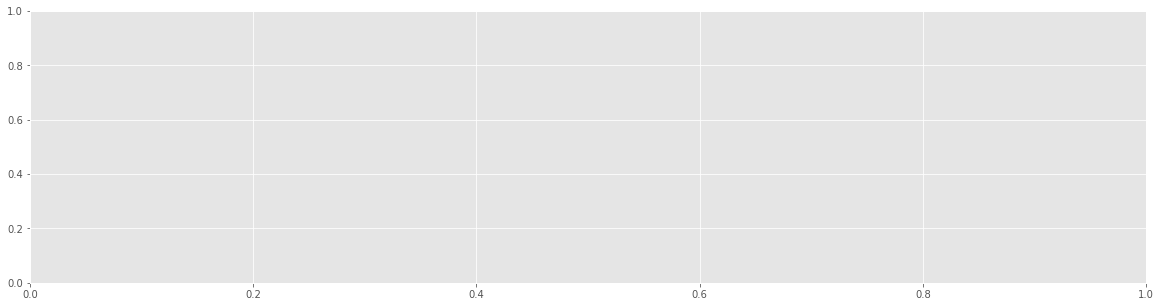

In [31]:
cv_models_tuned = []
models_tuned_names = ['LR', 'XGB', 'SVM']
cv_models_tuned.append(LR_tuned_cv)
cv_models_tuned.append(XGB_tuned_cv)
cv_models_tuned.append(SVM_tuned_cv)

fig, ax = plt.subplots(figsize=(20, 5))
plt.boxplots(cv_models_tuned)

In [32]:
scores_acc_SVM = cross_val_score(model_SVM, X_train, y_train, cv=kfold, scoring='accuracy')

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Random forest

In [33]:
parameters = {'clf__n_estimators':np.arange(1, 50), 'clf__max_features': np.arange(0.1, 1, 0.1), 'clf__min_samples_leaf': np.arange(1, 100, 10)} 
rf_grid = GridSearchCV(pipeline, param_grid=parameters, cv=5)

### 4. Model evaluation

In [34]:
new_clf_model = xgb.XGBClassifier(**grid_accu.best_params_)


NameError: name 'grid_accu' is not defined

### 5. Submission

In [35]:
model = XGBClassifier(random_state=random_state, colsample_bylevel= 0.9, colsample_bytree = 0.8, gamma=0.99, max_depth= 5, min_child_weight= 1, n_estimators= 10, nthread= 4, silent= True)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [36]:
submission = pd.DataFrame({'PassengerId': df_test_submission['PassengerId'],'Survived': y_pred})

filename = 'Titanic Predictions XGBoost Tuned.csv'

submission.to_csv(filename, index=False)

print('Saved file: ' + filename)

Saved file: Titanic Predictions XGBoost Tuned.csv


### 7. Appendices

##### Appendix1. Standard scaler test

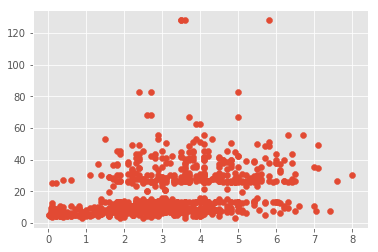

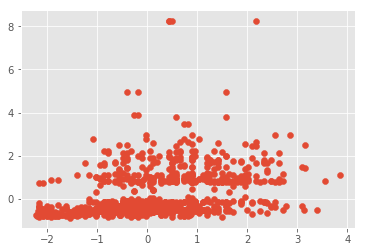

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

x = list(df['Age'].values/10)
y = list(df.Fare)

s = np.array(list(zip(x, y)))

plt.scatter(x, y)
plt.show()

scaler = StandardScaler()

sim = scaler.fit_transform(s)

plt.scatter(sim[:, 0], sim[:, 1])
plt.show()

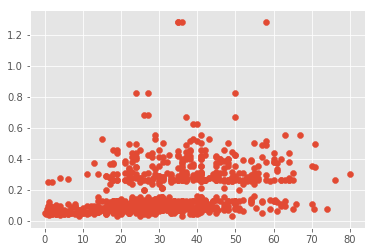

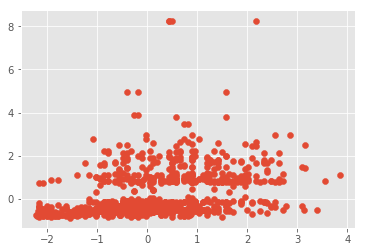

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

x = list(df['Age'].values)
y = list(df.Fare.values / 100)

s = np.array(list(zip(x, y)))

plt.scatter(x, y)
plt.show()

scaler = StandardScaler()

sim = scaler.fit_transform(s)

plt.scatter(sim[:, 0], sim[:, 1])
plt.show()

In [39]:
y

[0.0725,
 0.35641649999999997,
 0.07925,
 0.2655,
 0.0805,
 0.08458299999999999,
 0.2593125,
 0.04215,
 0.037111,
 0.150354,
 0.05566666666666666,
 0.2655,
 0.0805,
 0.04467857142857143,
 0.078542,
 0.16,
 0.04854166666666667,
 0.13,
 0.09,
 0.07225,
 0.13,
 0.13,
 0.08029199999999999,
 0.355,
 0.04215,
 0.04483928571428572,
 0.07225,
 0.43833333333333335,
 0.078792,
 0.078958,
 0.277208,
 0.4884026666666667,
 0.0775,
 0.105,
 0.410854,
 0.26,
 0.072292,
 0.0805,
 0.09,
 0.0562085,
 0.09475,
 0.105,
 0.078958,
 0.103948,
 0.078792,
 0.0805,
 0.0775,
 0.0775,
 0.07226400000000001,
 0.08900000000000001,
 0.056696428571428564,
 0.078,
 0.25576400000000005,
 0.13,
 0.309896,
 0.355,
 0.105,
 0.072292,
 0.069375,
 0.058625,
 0.072292,
 0.4,
 0.417375,
 0.04649999999999999,
 0.277208,
 0.05081933333333333,
 0.105,
 0.081583,
 0.07925,
 0.086625,
 0.105,
 0.058625,
 0.105,
 0.072271,
 0.07061975000000001,
 0.0765,
 0.078958,
 0.0805,
 0.09666666666666666,
 0.062375,
 0.09,
 0.095,
 0.077875,
